<h1><center>Stock Price Prediction using LSTM(Still need tunning) <br>and Signal Classification using SVM</center></h1>

Reference:
https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944<br>
https://github.com/DarkKnight1991/Stock-Price-Prediction<br>
Apple News:
https://www.apple.com/newsroom/archive/?page=2 <br>
Output:<br>
RMSE of Adjust close prediction<br>
Down/up prediction: confusion matrix , Sensitivity, Specificity, true positive rate, ROC<br>
Leading days: 3-day ahead

<h3>First</h3>
<h3>Train: 01/09/2015 to 31/08/2018</h3>
<h3>Test: 01/09/2018 to 31/08/2019</h3>

<h3>Second</h3>
<h3>Train: 01/09/2004 to 31/08/2014</h3>
<h3>Test: 01/09/2014 to 31/08/2015</h3>




In [242]:
import pandas as pd
import pandas_datareader.data as web   
import datetime
import matplotlib.pyplot as plt   # Import matplotlib
import numpy as np
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Permute
from keras.layers import merge, Input, concatenate, average, add
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector, AveragePooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from keras.constraints import *
from keras import regularizers
from keras import losses
from keras import optimizers
from sklearn import svm
import os
import pickle
from sklearn.multiclass import OneVsRestClassifier

import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging


#for ROC plot and confusion matrix
import numpy as np
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

### Import Apple stock data and Identify training set and testing set

In [2]:
start_train=datetime.datetime(2015, 9, 1)
end_train=datetime.datetime(2018, 8, 31)
start_test=datetime.datetime(2018, 9, 1)
end_test=datetime.datetime(2019, 8, 31)
apple_train=web.get_data_yahoo('AAPL',start_train,end_train)
apple_test=web.get_data_yahoo('AAPL',start_test,end_test)
apple_train
apple_test
	
print(len(apple_train))
print(len(apple_test))
apple_train.tail()


758
251


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-08-27,218.740005,216.330002,217.149994,217.940002,20525100.0,214.609741
2018-08-28,220.539993,218.919998,219.009995,219.699997,22776800.0,216.342850
2018-08-29,223.490005,219.410004,220.149994,222.979996,27254800.0,219.572723
2018-08-30,228.259995,222.399994,223.250000,225.029999,48793800.0,221.591385
2018-08-31,228.869995,226.000000,226.509995,227.630005,43340100.0,224.151657


<h5>We can see, there are 758 days in the training set, 251 days in the testing set. Now, we see how they look on plots:</h5>

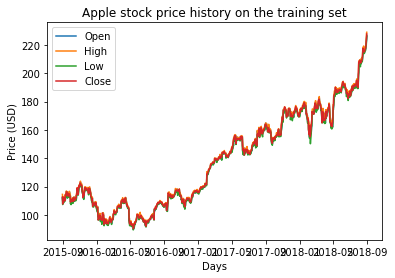

In [3]:
plt.figure()
plt.plot(apple_train["Open"])
plt.plot(apple_train["High"])
plt.plot(apple_train["Low"])
plt.plot(apple_train["Close"])
plt.title('Apple stock price history on the training set')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

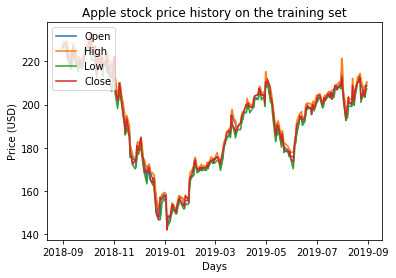

In [4]:
plt.figure()
plt.plot(apple_test["Open"])
plt.plot(apple_test["High"])
plt.plot(apple_test["Low"])
plt.plot(apple_test["Close"])
plt.title('Apple stock price history on the training set')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

<h5>We can see from the plot, there is no big difference between "open", "high", "close", "low" price. Now let’s check out the plot for volume :</h5>

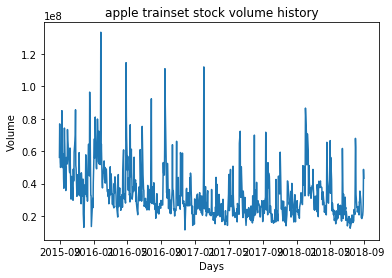

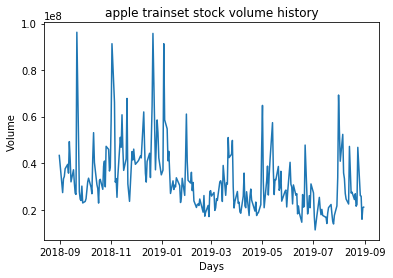

In [5]:
plt.figure()
plt.plot(apple_train["Volume"])
plt.title('apple trainset stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

plt.figure()
plt.plot(apple_test["Volume"])
plt.title('apple trainset stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

<h5>There is a little surge in the number of transactions around 201509--201701 in the training set and 201809--201901 on the timeline, which happens to coincide with the significant fluctuations or sudden drop of stock price. May be we can go back to that particular date and dig up old news articles to find what caused it.</h5>

<h5>Now let’s see if we have any null/Nan values to worry about. As it turns out we don’t have any null values. </h5>

In [10]:
print("checking if any null values are present\n", apple_train.isna().sum())
print("checking if any null values are present\n", apple_test.isna().sum())

checking if any null values are present
 High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64
checking if any null values are present
 High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64


## Normalizing the data

The data is not normalized and the range for each column varies, especially Volume. Normalizing data helps the algorithm in converging i.e. to find local/ global minimum efficiently. Here we use MinMaxScaler from Sci-kit Learn. But before that we have to split the dataset into training and testing datasets. Also I will convert the DataFrame to ndarray in the process.

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
train_cols = ["Open","High","Low","Close","Volume"]
test_cols = ["Open","High","Low","Close","Volume"]
# scale the feature MinMax, build array
x_train = apple_train.loc[:,train_cols].values
x_test= apple_test.loc[:,test_cols].values
min_max_scaler = MinMaxScaler()
#scale the training and the testing set
#transform the maximum value to 1, the minimum value to 0 and convert the remaining numbers proportionally 
x_train_scale = min_max_scaler.fit_transform(x_train)
x_test_scale = min_max_scaler.transform(apple_test.loc[:,test_cols])
print(x_test_scale)
print(x_train_scale)

[[1.         1.         1.         1.         0.26140952]
 [1.01391846 1.00225946 1.00461441 1.00531718 0.13055791]
 [1.01816725 1.00583093 0.99340809 0.9944642  0.17931265]
 ...
 [0.83583628 0.83126826 0.83388272 0.83902684 0.03661302]
 [0.86806831 0.85750737 0.85834618 0.86437461 0.07805647]
 [0.88022862 0.86574345 0.8623013  0.86240805 0.07931084]]
[[0.16138012 0.16661808 0.16501867 0.16330399 0.36715075]
 [0.14760825 0.1473032  0.13103347 0.12659337 0.53628651]
 [0.1481943  0.15065597 0.14399763 0.16024473 0.41358051]
 ...
 [0.95341    0.96078725 0.95173225 0.96613003 0.12944793]
 [0.976119   0.99555393 0.97363212 0.98106194 0.30615093]
 [1.         1.         1.         1.         0.26140952]]


## Build timeseries windows
Time_step is the time period of data used as input at each time;<br>
    Leading_days is the number of days ahead of the predicted day;<br>
    Features is the number of attributes used to represent each time step. Here if we use OHCLV values for prediction, then the feature number should be 5 .

In [25]:
def build_timeseries(mat, y_col_index, TIME_STEPS, LEADING_DAYS):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS-LEADING_DAYS
    dim_0 = mat.shape[0] - TIME_STEPS-LEADING_DAYS #number of time-series samples 
    dim_1 = mat.shape[1]# number of features
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(0,dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+LEADING_DAYS+i, y_col_index]#‘y_col_index’ is the index of your output column
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

 Now suppose after converting data into supervised learning format, we will have to trim your training set to remove the odd samples left out so that the batches could be devided properly. 
 Here, batch_size is the scale of data we use to update the weights once. 

In [26]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size 
    #here the input 'mat' should be the overall input time series data which has already been devided into windows 
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

### Create functions for turning price vector to signal vector

In [168]:
def turn_to_signal(vec):
    y = np.zeros(len(vec)-1)
    z = np.zeros(len(vec)-1)#return
    x = np.zeros([len(vec)-1,3])
    
    for i in range(0,len(vec)-1):
        y[i] = np.sign(vec[i+1]-vec[i])
        z[i]=vec[i+1]-vec[i]
        if (z[i]>0.005):#increase
            x[i,0]=1
        else:
            if (np.abs(z[i])<=0.005):#noise
                x[i,1]=1
            else:
                x[i,2]=1
    return  y,x

An example:

In [170]:
print(turn_to_signal([0.001,0.004,0.15,0.102])[0])
print(turn_to_signal([0.001,0.004,0.15,0.102])[1])


[ 1.  1. -1.]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


Now using the above functions lets form our train, validation and test datasets.

In [285]:
BATCH_SIZE=20
TIME_STEPS=30
LEADING_DAYS=3
OUTPUT_PATH="C:\\Users\Lenovo X240\\Documents\\Fintech\\8 weeks research"
epoch=50
lr=0.01
x_t, y_t = build_timeseries(x_train_scale, 3, TIME_STEPS, LEADING_DAYS)#data for train
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test_scale, 3,30,3)# x_temp contains the data for validation as well as for test
x_val, x_test_t = np.split(trim_dataset(x_temp,BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

#create set for signal classifier
y_t_sig=turn_to_signal(y_t)[0]
y_val_sig=turn_to_signal(y_val)[0]
y_test_sig=turn_to_signal(y_test_t)[0]

length of time-series i/o (725, 30, 5) (725,)
length of time-series i/o (218, 30, 5) (218,)


### Creating model for price prediction
We will be using LSTM for this task, which is a variation of Recurrent Neural Network. Creating LSTM model is as simple as this:

In [276]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=lr)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

As for finding the most proper tunning parameters, we will explore later.

In [277]:
csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'your_log_name' + '.log'), append=True)

history = lstm_model.fit(x_t, y_t, epochs=epoch, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])

Train on 720 samples, validate on 100 samples
Epoch 1/50
3s - loss: 0.0201 - val_loss: 0.0682
Epoch 2/50
0s - loss: 0.0257 - val_loss: 0.0835
Epoch 3/50
0s - loss: 0.0309 - val_loss: 0.0785
Epoch 4/50
0s - loss: 0.0226 - val_loss: 0.0721
Epoch 5/50
0s - loss: 0.0239 - val_loss: 0.0645
Epoch 6/50
0s - loss: 0.0193 - val_loss: 0.0795
Epoch 7/50
0s - loss: 0.0190 - val_loss: 0.0733
Epoch 8/50
0s - loss: 0.0172 - val_loss: 0.0655
Epoch 9/50
0s - loss: 0.0131 - val_loss: 0.0544
Epoch 10/50
0s - loss: 0.0100 - val_loss: 0.0590
Epoch 11/50
0s - loss: 0.0085 - val_loss: 0.0385
Epoch 12/50
0s - loss: 0.0068 - val_loss: 0.0485
Epoch 13/50
0s - loss: 0.0068 - val_loss: 0.0439
Epoch 14/50
0s - loss: 0.0064 - val_loss: 0.0420
Epoch 15/50
0s - loss: 0.0057 - val_loss: 0.0326
Epoch 16/50
0s - loss: 0.0057 - val_loss: 0.0289
Epoch 17/50
0s - loss: 0.0053 - val_loss: 0.0316
Epoch 18/50
0s - loss: 0.0056 - val_loss: 0.0143
Epoch 19/50
0s - loss: 0.0047 - val_loss: 0.0192
Epoch 20/50
0s - loss: 0.0048 - 

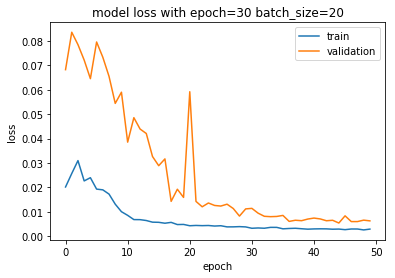

In [278]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with epoch=30 batch_size=20')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

### Evaluate price prediction model on validation set

Error is 0.009708444299941478 (100,) (100, 1)


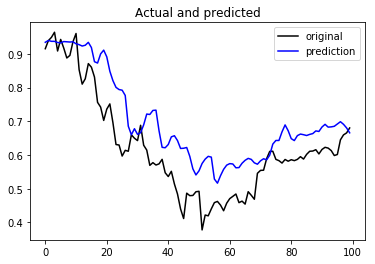

In [106]:
#test the accuraccy of the model
pred = lstm_model.predict(trim_dataset(x_val,BATCH_SIZE), batch_size=BATCH_SIZE)

predicted = pred
original = y_val
error = mean_squared_error(original, predicted)
print("Error is", error, original.shape, predicted.shape)
plt.title('Actual and predicted')
plt.plot(original, color='black', label = 'Original data')
plt.plot(pred, color='blue', label = 'Predicted data')
plt.legend(['original', 'prediction'],loc='best')
plt.show()

### Creating model for signal classifier


In [286]:
lstm_class_model = Sequential()
lstm_class_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_class_model.add(Dropout(0.25))
#lstm_class_model.add(Dense(20,activation='relu'))
lstm_class_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=lr)
lstm_class_model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [287]:
csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'your_log_name' + '.log'), append=True)

history = lstm_class_model.fit(trim_dataset(x_t[0:len(x_t)-1], BATCH_SIZE), trim_dataset(y_t_sig, BATCH_SIZE), epochs=epoch, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val[0:len(x_val)-1], BATCH_SIZE),
                    trim_dataset(y_val_sig, BATCH_SIZE)), callbacks=[csv_logger])

Train on 700 samples, validate on 80 samples
Epoch 1/50
3s - loss: 0.4827 - val_loss: 0.0027
Epoch 2/50
0s - loss: 0.2743 - val_loss: 0.0259
Epoch 3/50
0s - loss: 0.2202 - val_loss: 0.0230
Epoch 4/50
0s - loss: 0.2335 - val_loss: 0.0284
Epoch 5/50
0s - loss: 0.2049 - val_loss: 0.0281
Epoch 6/50
0s - loss: 0.2102 - val_loss: 0.0267
Epoch 7/50
0s - loss: 0.1960 - val_loss: 0.0287
Epoch 8/50
0s - loss: 0.2537 - val_loss: 0.0293
Epoch 9/50
0s - loss: 0.2228 - val_loss: 0.0271
Epoch 10/50
0s - loss: 0.2104 - val_loss: 0.0277
Epoch 11/50
0s - loss: 0.2008 - val_loss: 0.0240
Epoch 12/50
0s - loss: 0.2117 - val_loss: 0.0292
Epoch 13/50
0s - loss: 0.2498 - val_loss: 0.0250
Epoch 14/50
0s - loss: 0.2120 - val_loss: 0.0272
Epoch 15/50
0s - loss: 0.2274 - val_loss: 0.0286
Epoch 16/50
0s - loss: 0.2401 - val_loss: 0.0295
Epoch 17/50
0s - loss: 0.2348 - val_loss: 0.0286
Epoch 18/50
0s - loss: 0.2018 - val_loss: 0.0245
Epoch 19/50
0s - loss: 0.2358 - val_loss: 0.0290
Epoch 20/50
0s - loss: 0.1918 - v

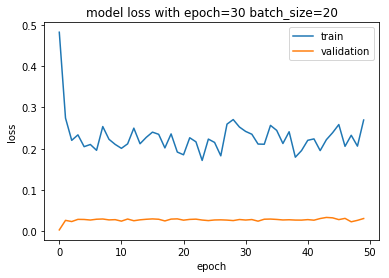

In [288]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with epoch=30 batch_size=20')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

Problem occurs!

### Evaluate  signal classifier model on validation set

In [132]:
pred_signal = lstm_class_model.predict(trim_dataset(x_val[0:len(x_val)-1],BATCH_SIZE), batch_size=BATCH_SIZE)

predicted_sig =pred_signal
original_sig = y_val_sig
print(predicted_sig[:10])

[[0.01734778]
 [0.01734778]
 [0.01734778]
 [0.01734778]
 [0.01734778]
 [0.01734778]
 [0.01734778]
 [0.01734778]
 [0.01734778]
 [0.01734778]]


Tragedy!<br>
### Try SVM for classification Instead.

In [213]:
#create set for signal classifier, again
y_t_sig=turn_to_signal(y_t)[1]
y_val_sig=turn_to_signal(y_val)[1]
y_test_sig=turn_to_signal(y_test_t)[1]
print(sum(y_t_sig))

[231. 304. 184.]


reshape the data set for fitting the model

In [257]:
x_sig_t=x_t[0:len(x_t)-1]
x_sig_val=x_val[0:len(x_val)-1]
nsamples, nx, ny = x_sig_t.shape
x_sig_t =x_sig_t.reshape((nsamples,nx*ny))
nsamples1, nx1, ny1 = x_sig_val.shape
x_sig_val =x_sig_val.reshape((nsamples1,nx1*ny1))

Build the model

In [258]:
random_state = np.random.RandomState(0)
classifier = OneVsRestClassifier(svm.SVC(kernel='poly', probability=True,
                                 random_state=random_state))# kernel must be ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ 
y_pre = classifier.fit(x_sig_t, y_t_sig).decision_function(x_sig_val)
y_pre[1:10]

class_pre=y_pre.argmax(axis=1)
class_org=y_val_sig.argmax(axis=1)

C:\Users\Lenovo X240\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lenovo X240\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lenovo X240\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [259]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val_sig[:, i], y_pre[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_sig.ravel(), y_pre.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

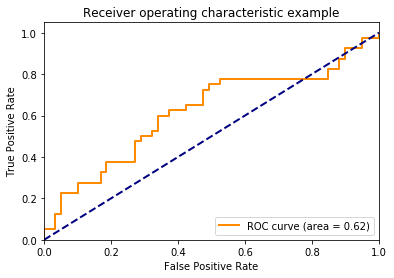

In [260]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Seeems much better, next we calculate the confusion matrix.

In [261]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Confusion matrix, without normalization
[[26 12  3]
 [10  4  4]
 [29  9  2]]
Normalized confusion matrix
[[0.63414634 0.29268293 0.07317073]
 [0.55555556 0.22222222 0.22222222]
 [0.725      0.225      0.05      ]]


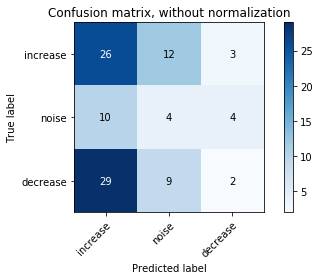

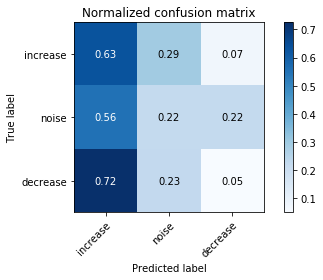

In [262]:
class_names=np.array(['increase', 'noise', 'decrease'])
# Plot non-normalized confusion matrix
plot_confusion_matrix(class_org, class_pre, class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(class_org, class_pre, class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## For test set

In [280]:
# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 0.004105459070546681 (100,) (100,)
[0.65844303 0.68604344 0.7040348  0.73797584 0.7607894  0.7889403
 0.78559244 0.7872782  0.8028749  0.83826315 0.80452013 0.75861156
 0.77456737 0.76636875 0.75511074]
[0.69764726 0.71148665 0.70063367 0.71250638 0.76298342 0.73355671
 0.71673103 0.70252743 0.71476436 0.71658532 0.72554443 0.73494066
 0.75518976 0.76487729 0.76735377]


In [281]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[180.73764 184.52692 186.99695 191.65671 194.78879 198.65363 198.19398
 198.42542 200.56671 205.42516 200.79257 194.48978 196.68036 195.55478
 194.00916]
[186.11999512 188.02000427 186.52999878 188.16000366 195.08999634
 191.05000305 188.74000549 186.78999329 188.47000122 188.72000122
 189.94999695 191.24000549 194.02000427 195.3500061  195.69000244]


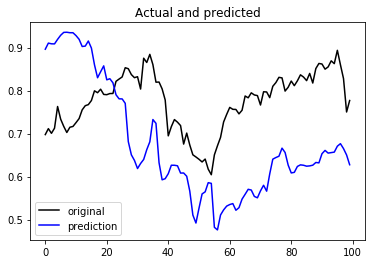

In [282]:
#visualize the prediction result on test set

predicted = y_pred
original = y_test_t

plt.title('Actual and predicted')
plt.plot(original, color='black', label = 'Original data')
plt.plot(pred, color='blue', label = 'Predicted data')
plt.legend(['original', 'prediction'],loc='best')
plt.show()

### Classification model on testing set

C:\Users\Lenovo X240\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lenovo X240\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lenovo X240\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


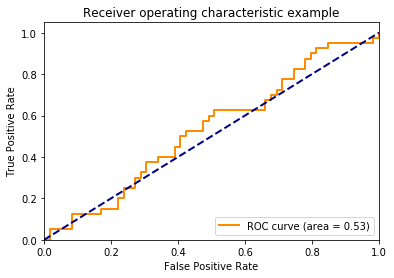

In [272]:

x_sig_test=x_test_t[0:len(x_test_t)-1]
nsamples1, nx1, ny1 = x_sig_test.shape
x_sig_test =x_sig_test.reshape((nsamples1,nx1*ny1))
random_state = np.random.RandomState(0)
classifier = OneVsRestClassifier(svm.SVC(kernel='poly', probability=True,
                                 random_state=random_state))# kernel must be ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ 
y_pre = classifier.fit(x_sig_t, y_t_sig).decision_function(x_sig_test)

class_pre=y_pre.argmax(axis=1)
class_org=y_test_sig.argmax(axis=1)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val_sig[:, i], y_pre[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_sig.ravel(), y_pre.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Confusion matrix, without normalization
[[11 32  1]
 [ 6 12  0]
 [14 21  2]]
Normalized confusion matrix
[[0.25       0.72727273 0.02272727]
 [0.33333333 0.66666667 0.        ]
 [0.37837838 0.56756757 0.05405405]]


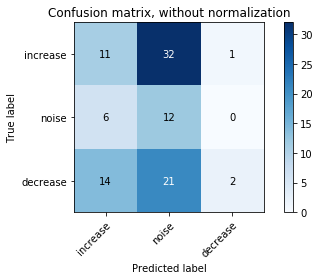

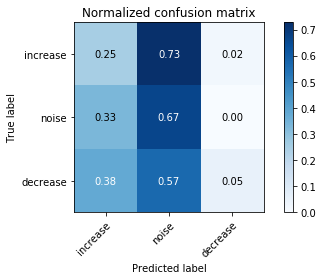

In [273]:
class_names=np.array(['increase', 'noise', 'decrease'])
# Plot non-normalized confusion matrix
plot_confusion_matrix(class_org, class_pre, class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(class_org, class_pre, class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()